# Usage

## Dependencies

We start by importing some of ProMis' core packages and third party dependencies.

In [1]:
# Probabilistic Mission Design and Statistical Relational Maps
from promis import ProMis, StaRMap
# Geographic data handling
from promis.geo import PolarLocation, CartesianMap, CartesianLocation, CartesianRasterBand, CartesianCollection
# Data loading from OpenStreetMap
from promis.loaders import OsmLoader

# Third Party dependencies we will need
from numpy import eye
import matplotlib.pyplot as plt
from os.path import exists

## Uncertainty Annotated Maps

Probabilistic missions are built on an uncertainty aware environment representation we call Uncertainty Annotated Maps (UAM).
Here, to obtain a UAM, we query crowd-sourced data from OpenStreetMap (OSM) using ProMis' OsmLoader class.
The OsmLoader expects a feature description consisting of a location type that identifies the respective set of features and a 'filter' describing the OSM tags and their values to be selected.

In [2]:
# The features we will load from OpenStreetMap
# The dictionary key will be stored as the respective features location_type
# The dictionary value will be used to query the relevant geometry via Overpass
feature_description = {
    "park": "['leisure' = 'park']",
    "primary": "['highway' = 'primary']",
    "secondary": "['highway' = 'secondary']",
    "tertiary": "['highway' = 'tertiary']",
    "service": "['highway' = 'service']",
    "crossing": "['footway' = 'crossing']",
    "bay": "['natural' = 'bay']",
    "rail": "['railway' = 'rail']",
}

Since we do not know how noisy the OSM data actually is, we define some noise ourselves for demonstration purposes.
In an actual application, you would insert your (neural) sensors and mapping modules' accuracy information here.

Here, the environment features will be assumed to be placed where we expect them with a random translation sampled from a Gaussian with one of the following covariance matrices.

In [3]:
# Covariance matrices for some of the features
# Used to draw random translations representing uncertainty for the respective features
covariance = {
    "primary": 15 * eye(2),
    "secondary": 10 * eye(2),
    "tertiary": 5 * eye(2),
    "service": 2.5 * eye(2),
    "operator": 20 * eye(2),
}

As a last piece of information before the UAM can be queried, we need to define the area in which our agent's mission will take place in.

In [4]:
# The mission area's origin in polar coordinates as well as area extends in meters
origin = PolarLocation(latitude=49.878091, longitude=8.654052)
width, height = 1000.0, 1000.0

Finally, we can query the relevant environment features from OSM.
We also apply our uncertainties in the data, place the position of the agent's operator at the center of the mission area, and store the resulting UAM to disk.

Note that this step requires a working internet connection.

In [5]:
# Setting up the Uncertainty Annotated Map from OpenStreetMap data
uam = OsmLoader(origin, (width, height), feature_description, timeout=5.0).to_cartesian_map()

# Adding the operator's location and applying out assumed levels of uncertainty
uam.features.append(CartesianLocation(0.0, 0.0, location_type="operator"))
uam.apply_covariance(covariance)

# We store the UAM to disk for later usage
uam.save(f"data/uam.pkl")

## Statistical Relational Maps

Equipped with the UAM from the last steps, it is time to prepare a StaR Map of the environment.
Before fitting the actual StaR Map parameters, we should now start considering our actual mission requirements and state some rules that will govern our agent's actions.
If we don't make these consideration now, we could still compute a StaR Map, but this way we can automize the choice of which spatial relations ought to be computed.

Here, we will define our knowledge in Hybrid ProbLog where rules are written as clauses parameterized either by a probability density function (e.g., as in the `initial_charge` clause) or a probability (e.g., as in the `vlos` clause).
One reads a comma `,` as a conjunction (AND), and a semicolon as a disjunction (OR).
We refer to an agent's state (here, its east/north location in a Cartesian coordinate system) with the variable `X`.

For example, our toy example assumes visual line of sight (VLOS) is likely given (P = 0.8) if we have foggy weather and the distance to the operator is less than 50 meters, or if the weather is clear and the distance is within 100 meters.

In [6]:
# Properties of the agent perceived through sensors or external sources
# such as the weather report 
perception = """
    % UAV properties
    initial_charge ~ normal(90, 5).
    charge_cost ~ normal(-0.1, 0.2).
    weight ~ normal(0.2, 0.1).

    % Weather conditions
    1/10::fog; 9/10::clear.
"""

# Background knowledge on rules that we want to govern an aerial agents' actions
background_knowledge = """
    % Visual line of sight
    0.8::vlos(X) :- 
        fog, distance(X, operator) < 50;
        clear, distance(X, operator) < 100;
        clear, over(X, bay), distance(X, operator) < 400.

    % Sufficient charge to return to operator
    can_return(X) :-
        B is initial_charge, O is charge_cost,
        D is distance(X, operator), 0 < B + (2 * O * D).

    % Permits related to local features
    permits(X) :- 
        distance(X, service) < 15; 
        distance(X, primary) < 15;
        distance(X, secondary) < 10; 
        distance(X, tertiary) < 5;
        distance(X, rail) < 5; 
        distance(X, crossing) < 5; 
        over(X, park).
"""

# The definition of our probabilistic mission landscape that will be queried by ProMis
landscape_definition = """
    % Definition of a valid mission
    landscape(X) :- 
        vlos(X), weight < 25, can_return(X); 
        permits(X), can_return(X).
"""

Now its time to compute the StaR Map.
For this, we load the UAM from disk, define some points in the mission area to compute the StaR Map for and initialize it for the rules we defined above.

In [7]:
# Setting up the probabilistic spatial relations from the UAM we previously computed
star_map = StaRMap(CartesianMap.load(f"data/uam.pkl"))

# Initializing the StaR Map on a raster of points evenly spaced out across the mission area,
# sampling 25 random variants of the UAM for estimating the spatial relation parameters
evaluation_points = CartesianRasterBand(origin, (15, 15), width, height)
star_map.initialize(evaluation_points, number_of_random_maps=25, logic=background_knowledge)

# We store the StaR Map to disk
star_map.save(f"data/star_map.pkl")

Let's inspect the parameters of the StaR Map relations by visualizing the estimated values.
We do so by accessing the parameters (a `promis.geo.Collection` holding mean and variances for each sampled point), and interpolating to a more fine-granular grid over the mission area.

In [8]:
# Visualize the spatial relations with an OSM basemap in the background
def show_collection(collection, value_index, ax, title):
    # Fine-granular interpolation target for the spatial relations
    mission_area = CartesianRasterBand(collection.origin, (300, 300), width, height)

    image = collection.into(mission_area).scatter(value_index=value_index, ax=ax, s=0.4, plot_basemap=True, rasterized=True, cmap="coolwarm_r", alpha=0.25)
    cbar = plt.colorbar(image, aspect=18.5, fraction=0.05, pad=0.02)
    cbar.solids.set(alpha=1)
    ax.set_title(title)

def set_style():
    # Set axes labeling
    ticks = [-width / 2.0, 0, width / 2.0]
    labels = ["0", "0.5", "1"]
    axes[0].set_ylabel("Northing / km")
    axes[0].set_yticks(ticks, labels)
    axes[0].set_ylim([-height / 2.0, height / 2.0])
    for ax in axes:
        ax.set_xlabel("Easting / km")
        ax.set_xticks(ticks, labels)
        ax.set_xlim([-width / 2.0, width / 2.0])

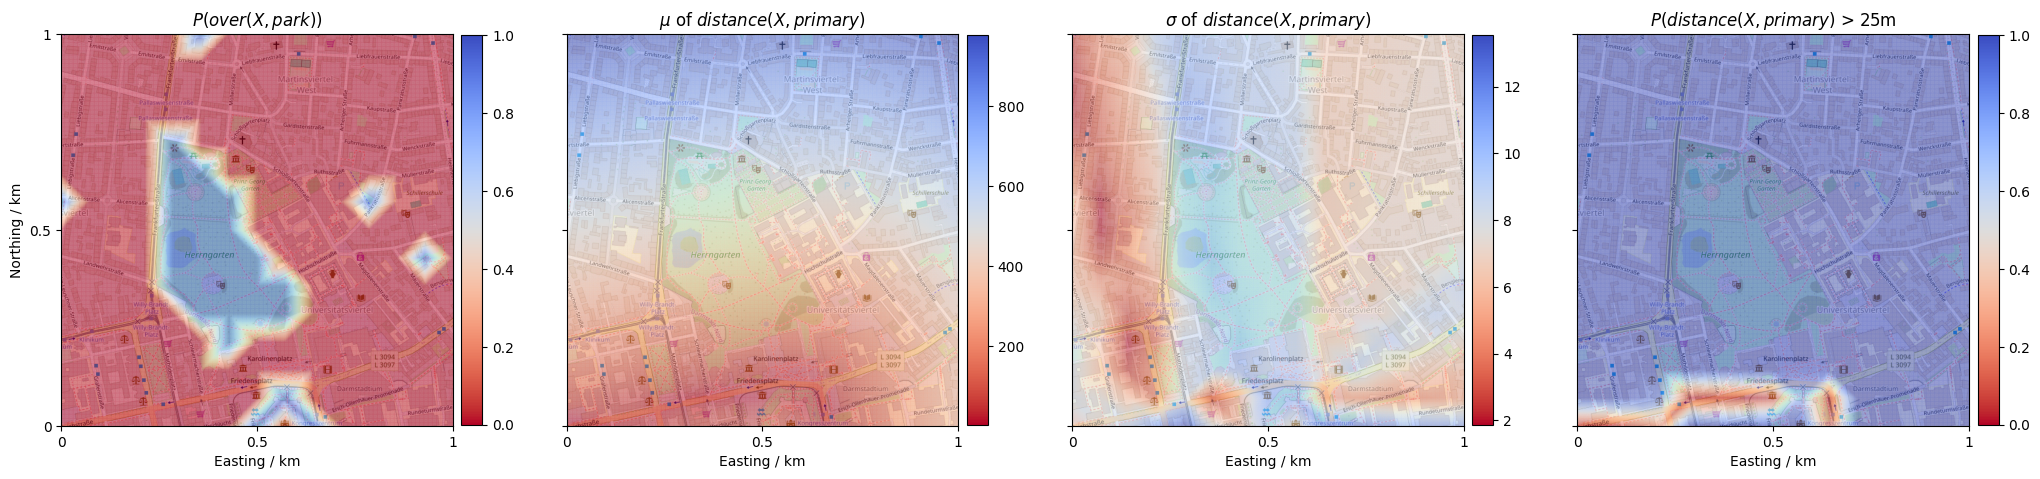

In [9]:
# Load the StaR Map data and prepare the figure
star_map = StaRMap.load(f"data/star_map.pkl")
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(25, 10))

# We can query each relation from the StaR Map given its name and the location type it relates to
over_park = star_map.get("over", "park")
distance_primary = star_map.get("distance", "primary")

show_collection(over_park.parameters, 0, axes[0], r'$P(over(X, park))$')
show_collection(distance_primary.parameters, 0, axes[1], r'$\mu$ of $distance(X, primary)$')
show_collection(distance_primary.parameters, 1, axes[2], r'$\sigma$ of $distance(X, primary)$')
show_collection(distance_primary > 25, 0, axes[3], r'$P(distance(X, primary)$ > 25m')

# Show results
set_style()
plt.show()

While this already allows us some reasoning with ProMis on what the agent may or may not be allowed to do, we should improve the spatial resolution of our relations before continuing.
We can do so by applying StaR Maps adaptive sampling functionality, which will sample each relation based on an acquisition function.
Currently, local entropy and Gaussian Process uncertainty together with a distance based score are provided.

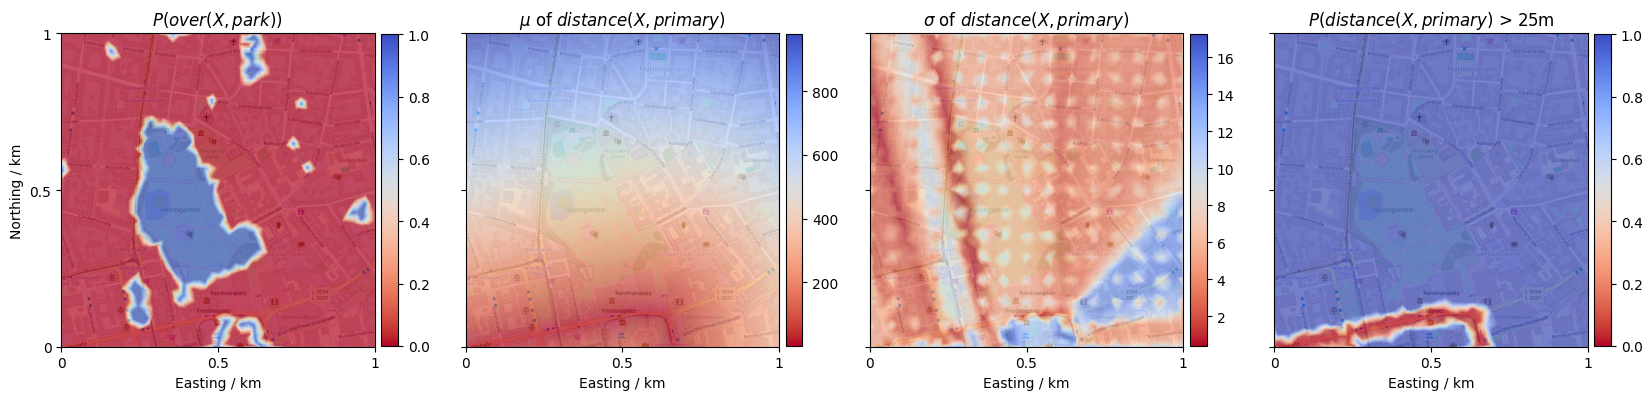

In [10]:
# Load the StaR Map data and run an auto-improvement, store the improved one
star_map = StaRMap.load(f"data/star_map.pkl")
star_map.adaptive_sample(
    candidate_sampler=lambda: CartesianCollection.make_latin_hypercube(origin, width, height, number_of_samples=1000, include_corners=True),
    number_of_random_maps=5,
    number_of_iterations=15,
    number_of_improvement_points=100,
    acquisition_method = "gaussian_process"
)
star_map.save(f"data/improved_star_map.pkl")

# Show the improved spatial relations
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(20, 7.5))

# We can query each relation from the StaR Map given its name and the location type it relates to
over_park = star_map.get("over", "park")
distance_primary = star_map.get("distance", "primary")

show_collection(over_park.parameters, 0, axes[0], r'$P(over(X, park))$')
show_collection(distance_primary.parameters, 0, axes[1], r'$\mu$ of $distance(X, primary)$')
show_collection(distance_primary.parameters, 1, axes[2], r'$\sigma$ of $distance(X, primary)$')
show_collection(distance_primary > 25, 0, axes[3], r'$P(distance(X, primary)$ > 25m')

# Show results
set_style()
plt.show()

## Probabilistic Mission Design

We can now continue employing ProMis' core functionality: The inference of Probabilistic Mission Landscapes (PML).
A PML is a scalar field that expresses at each point in the agent's state-space how probable the stated rules of the `landscape` clause are satisfied.

To do so, we employ the `ProMis` class.
Similarly to the sampling of StaR Map relations, we can provide ProMis with evaluation points to solve for and approximate the rest of the PML.
Furthermore, ProMis can also run an adaptive solving scheme to improve its spatial accuracy.

In [11]:
# Load the improved StaRMap and evaluate 
promis = ProMis(StaRMap.load(f"data/improved_star_map.pkl"))

# Solve an initial landscape from a few samples
program = perception + background_knowledge + landscape_definition
landscape = CartesianCollection.make_latin_hypercube(origin, width, height, number_of_samples=25, include_corners=True)
promis.solve(landscape, logic=program, n_jobs=4, batch_size=1)
landscape.save(f"data/initial_landscape.pkl")

# Improve the landscape twice to show the effect of the adaptive solve function
promis.adaptive_solve(
    landscape, 
    logic=program, 
    candidate_sampler=lambda: CartesianCollection.make_latin_hypercube(origin, width, height, number_of_samples=1000, include_corners=True), 
    n_jobs=4, 
    batch_size=1, 
    number_of_improvement_points=100, 
    number_of_iterations=5,
    acquisition_method="gaussian_process"
)
landscape.save(f"data/improved_landscape.pkl")

promis.adaptive_solve(
    landscape, 
    logic=program, 
    candidate_sampler=lambda: CartesianCollection.make_latin_hypercube(origin, width, height, number_of_samples=1000, include_corners=True), 
    n_jobs=4, 
    batch_size=25, 
    number_of_improvement_points=100, 
    number_of_iterations=5,
    acquisition_method="gaussian_process"
)
landscape.save(f"data/twice_improved_landscape.pkl")

Let's inspect the resulting landscapes!
Blue regions indicate high probability of satisfying all constraints, and red areas should be strictly avoided.

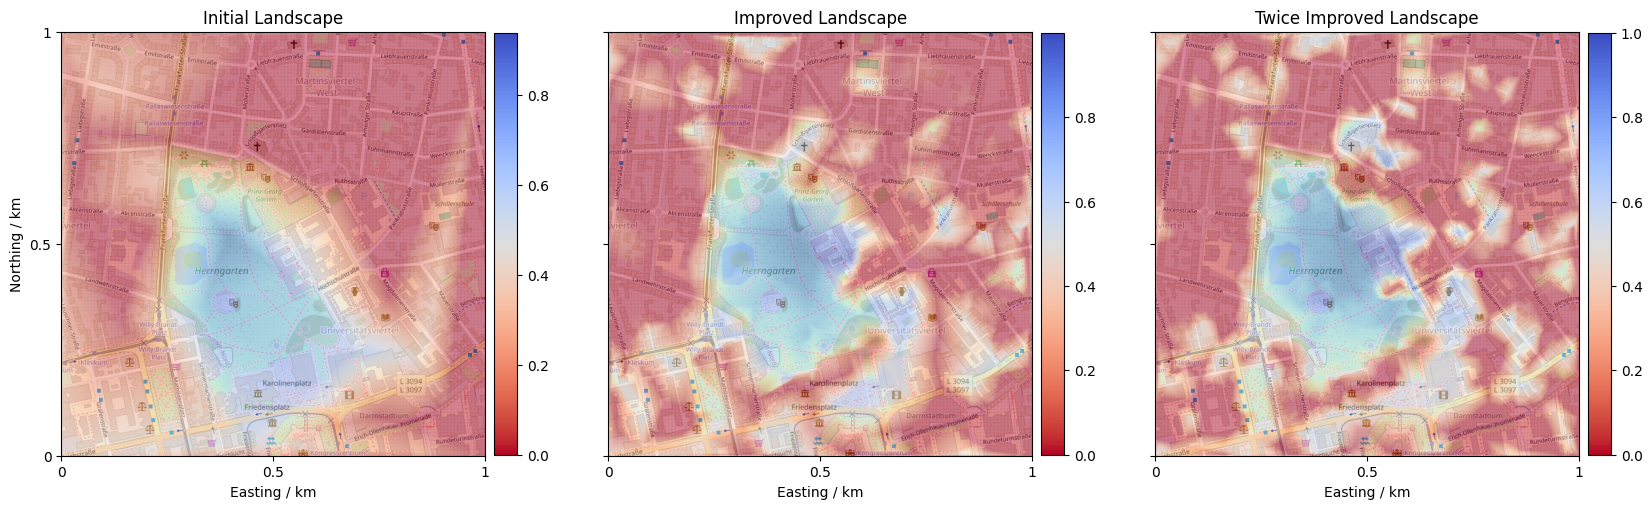

In [12]:
# Show the Probabilistic Mission Landscapes we obtained
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(20, 7.5))

# Load and scatter each landscape
show_collection(CartesianCollection.load("data/initial_landscape.pkl"), 0, axes[0], r'Initial Landscape')
show_collection(CartesianCollection.load("data/improved_landscape.pkl"), 0, axes[1], r'Improved Landscape')
show_collection(CartesianCollection.load("data/twice_improved_landscape.pkl"), 0, axes[2], r'Twice Improved Landscape')

# Show results
set_style()
plt.show()